<a href="https://colab.research.google.com/github/t1nh233/predict_vnindex_stacked_lstm/blob/main/notebooks/lstm_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
import os
import subprocess

REPO_URL = "https://github.com/t1nh233/predict_vnindex_stacked_lstm.git"
PROJECT_NAME = "predict_vnindex_stacked_lstm"

def init_project():
    if not os.path.exists(PROJECT_NAME):
        try:
            subprocess.run(["git", "clone", REPO_URL], check=True)
        except Exception:
            return False

    try:
        os.chdir(PROJECT_NAME)
    except FileNotFoundError:
        return False

    current_path = os.getcwd()
    if current_path not in sys.path:
        sys.path.insert(0, current_path)

    if not os.path.exists("src"):
        return False

    pkgs = ["numpy<2.0.0", "pandas_ta", "optuna", "pandas", "scikit-learn", "torch", "matplotlib"]
    subprocess.run([sys.executable, "-m", "pip", "install"] + pkgs + ["-q"])

    return True

if init_project():
    try:
        import json
        import torch
        import torch.nn as nn
        import torch.optim as optim
        import optuna
        import matplotlib.pyplot as plt
        import numpy as np
        import pandas_ta as ta
        import pandas as pd
        import joblib

        # Import từ src
        from src.utils import (
            load_and_process_data, feature_extraction, split_data,
            scale_data, create_sliding_window, train_model,
            validate_model, predict_model, inverse_transform_target, cal_metrics
        )
        from src.model import LSTMModel
    except ImportError:
        pass

BASE_DIR = os.getcwd()


In [2]:
## Load du lieu
url = "https://raw.githubusercontent.com/t1nh233/predict_vnindex_stacked_lstm/refs/heads/main/data/raw/vn_index_historical_data_9_12.csv"
vnindex = load_and_process_data(url)

## Xu ly cac dac trung moi
vnindex_feature = feature_extraction(vnindex)

## Cac dac trung su dung de huan luyen
FEATURE_COLUMNS = ['Close', 'Volume', 'RSI', 'SMA', 'EMA', 'MACD_Hist', 'BB_Width', 'BB_Percentage']
TARGET_COLUMN = 'Label'

## Trich xuat du lieu theo cac dac trung huan luyen
feature_data = vnindex_feature[FEATURE_COLUMNS + [TARGET_COLUMN]].copy()
TARGET_INDEX = feature_data.columns.get_loc(TARGET_COLUMN)

## Chia tap du lieu train, valid, set theo ti le 70:20:10
train_df, val_df, test_df = split_data(feature_data, 0.7, 0.2)

## Scale data ve (0, 1)
scaler, train_scaled_df, val_scaled_df, test_scaled_df = scale_data(train_df, val_df, test_df, FEATURE_COLUMNS + [TARGET_COLUMN])

## Tao input (sliding window) cho LSTM
WINDOW_SIZE = 30
X_train, y_train = create_sliding_window(train_scaled_df, WINDOW_SIZE)
X_val, y_val = create_sliding_window(val_scaled_df, WINDOW_SIZE)
X_test, y_test = create_sliding_window(test_scaled_df, WINDOW_SIZE)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
val_dataset = torch.utils.data.TensorDataset(X_val, y_val)

In [3]:
MODEL_DIR = os.path.join(BASE_DIR, 'models')
RESULT_DIR = os.path.join(BASE_DIR, 'results')
FIGURE_DIR = os.path.join(BASE_DIR, 'figures')

# Tạo thư mục (nếu chưa có)
for d in [MODEL_DIR, RESULT_DIR, FIGURE_DIR]:
    os.makedirs(d, exist_ok=True)

In [4]:
## Dieu chinh tham so cua mo hinh (chon ra bo tham so tot nhat)

def hyper_tuning(trial):
  ## Sieu tham so cho model
  hidden_size = trial.suggest_categorical("hidden_size", [32, 64, 128, 256])
  num_layers = trial.suggest_int("num_layers", 2, 2)
  dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)

  ## Sieu tham so cho optimizer
  learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)
  weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-3, log=True)

  batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])

  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
  val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

  ## Khoi tao model
  model = LSTMModel(
      input_size = X_train.shape[2],
      hidden_size = hidden_size,
      num_layers = num_layers,
      dropout_rate = dropout_rate
  ).to(device)

  loss_func = nn.HuberLoss(delta=1.0)
  optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

  ## Training voi epoch 10 tren train de test
  for epoch in range(10):
    model.train()
    for X_batch, y_batch in train_loader:
      X_batch, y_batch = X_batch.to(device), y_batch.to(device)

      optimizer.zero_grad()
      y_pred = model(X_batch)
      loss = loss_func(y_batch, y_pred)
      loss.backward()

      torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
      optimizer.step()

  ## Validate
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
      for X_batch_v, y_batch_v in val_loader:
        X_batch_v, y_batch_v = X_batch_v.to(device), y_batch_v.to(device)

        y_pred_v = model(X_batch_v)
        loss = loss_func(y_batch_v, y_pred_v)
        val_loss += loss.item()

    ## In ra ket qua khi chay tren bo tham so nay
    avg_val_loss = val_loss / len(val_loader)
    trial.report(avg_val_loss, epoch)

    if trial.should_prune():
      raise optuna.exceptions.TrialPruned()

  return avg_val_loss

## Bat dau chay
print("Start tuning")
study = optuna.create_study(direction="minimize")
study.optimize(hyper_tuning, n_trials=20)

## Tra ve bo tham so toi uu nhat
print("Best parameter: ", study.best_params)
best_params = study.best_params

## Luu best params vao file
best_params_config = {
    "window_size": WINDOW_SIZE,
    "feature_columns": FEATURE_COLUMNS,
    **best_params
}

params_path = os.path.join(MODEL_DIR, 'best_params.json')
with open(params_path, 'w') as f:
    json.dump(best_params_config, f, indent=4)

[I 2026-01-03 06:48:32,325] A new study created in memory with name: no-name-c0db7b25-3c51-4579-8f88-7c879610858f


Start tuning


[I 2026-01-03 06:48:43,112] Trial 0 finished with value: 0.0021166232536020484 and parameters: {'hidden_size': 256, 'num_layers': 2, 'dropout_rate': 0.41638609321854725, 'learning_rate': 4.4552847749225396e-05, 'weight_decay': 9.877756878643065e-06, 'batch_size': 32}. Best is trial 0 with value: 0.0021166232536020484.
[I 2026-01-03 06:48:44,517] Trial 1 finished with value: 0.0016968023275770368 and parameters: {'hidden_size': 64, 'num_layers': 2, 'dropout_rate': 0.16830831440804972, 'learning_rate': 0.004544725257126454, 'weight_decay': 1.5210392380617199e-06, 'batch_size': 64}. Best is trial 1 with value: 0.0016968023275770368.
[I 2026-01-03 06:48:45,631] Trial 2 finished with value: 0.0023292472469620407 and parameters: {'hidden_size': 128, 'num_layers': 2, 'dropout_rate': 0.24751940657502428, 'learning_rate': 0.002335988421471428, 'weight_decay': 1.1113328649157723e-05, 'batch_size': 128}. Best is trial 1 with value: 0.0016968023275770368.
[I 2026-01-03 06:48:46,794] Trial 3 finish

Best parameter:  {'hidden_size': 128, 'num_layers': 2, 'dropout_rate': 0.11246190508042161, 'learning_rate': 0.0002365025795809892, 'weight_decay': 7.121061873857167e-05, 'batch_size': 32}


Start training
Epoch [5/100], Train Loss: 0.00214, Val Loss: 0.00093
Epoch [10/100], Train Loss: 0.00103, Val Loss: 0.00088
Epoch [15/100], Train Loss: 0.00118, Val Loss: 0.00048
Epoch [20/100], Train Loss: 0.00087, Val Loss: 0.00043
Epoch [25/100], Train Loss: 0.00125, Val Loss: 0.00047
Epoch [30/100], Train Loss: 0.00075, Val Loss: 0.00045
Epoch [35/100], Train Loss: 0.00093, Val Loss: 0.00051
Epoch [40/100], Train Loss: 0.00081, Val Loss: 0.00060
Epoch [45/100], Train Loss: 0.00085, Val Loss: 0.00070
Epoch [50/100], Train Loss: 0.00075, Val Loss: 0.00047
Epoch [55/100], Train Loss: 0.00094, Val Loss: 0.00059
Epoch [60/100], Train Loss: 0.00069, Val Loss: 0.00060
Epoch [65/100], Train Loss: 0.00074, Val Loss: 0.00054
Epoch [70/100], Train Loss: 0.00096, Val Loss: 0.00115
Epoch [75/100], Train Loss: 0.00054, Val Loss: 0.00076
Epoch [80/100], Train Loss: 0.00078, Val Loss: 0.00084
Epoch [85/100], Train Loss: 0.00058, Val Loss: 0.00082
Epoch [90/100], Train Loss: 0.00058, Val Loss: 0.00

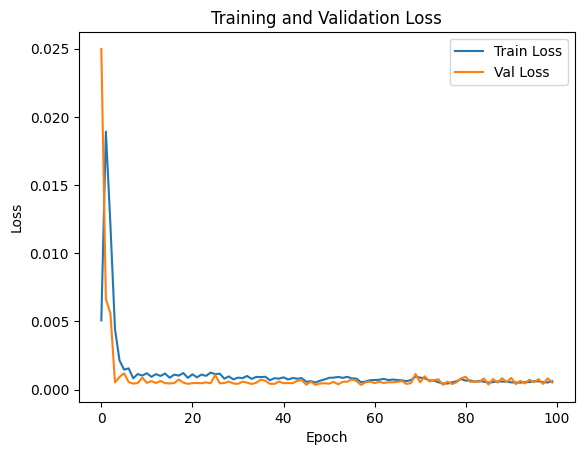

In [5]:
## Huan luyen mo hinh
final_batch_size = best_params['batch_size']
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=final_batch_size, shuffle=False)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=final_batch_size, shuffle=False)

model = LSTMModel(
    input_size = X_train.shape[2],
    hidden_size = best_params['hidden_size'],
    num_layers = best_params['num_layers'],
    dropout_rate = best_params['dropout_rate']
).to(device)

loss_func = nn.HuberLoss(delta=1.0)
optimizer = optim.AdamW(model.parameters(), lr=best_params['learning_rate'], weight_decay=best_params['weight_decay'])

NUM_EPOCHS = 100
best_val_loss = float('inf')
history = {'train_loss': [], 'val_loss': []}

print("Start training")
model_save_path = os.path.join(MODEL_DIR, 'best_vnindex_lstm.pth')

for epoch in range(NUM_EPOCHS):
  avg_train_loss = train_model(model, train_loader, loss_func, optimizer, device)
  avg_val_loss = validate_model(model, val_loader, loss_func, device)

  history['train_loss'].append(avg_train_loss)
  history['val_loss'].append(avg_val_loss)

  if avg_val_loss < best_val_loss:
    best_val_loss = avg_val_loss
    torch.save(model.state_dict(), model_save_path)


  if (epoch + 1) % 5 == 0:
    print(f'Epoch [{epoch + 1}/{NUM_EPOCHS}], Train Loss: {avg_train_loss:.5f}, Val Loss: {avg_val_loss:.5f}')

scaler_path = os.path.join(MODEL_DIR, 'scaler.pkl')
joblib.dump(scaler, scaler_path)

## Luu lich su huan luyen
history_path = os.path.join(RESULT_DIR, 'training_history.csv')
pd.DataFrame(history).to_csv(history_path, index=False)

## Ve bieu do train_loss va val_loss
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

loss_chart_path = os.path.join(FIGURE_DIR, 'loss_chart.png')
plt.savefig(loss_chart_path)

plt.show()

MAE: 32.10 điểm
RMSE: 42.20 điểm
R2 Score: 0.9428


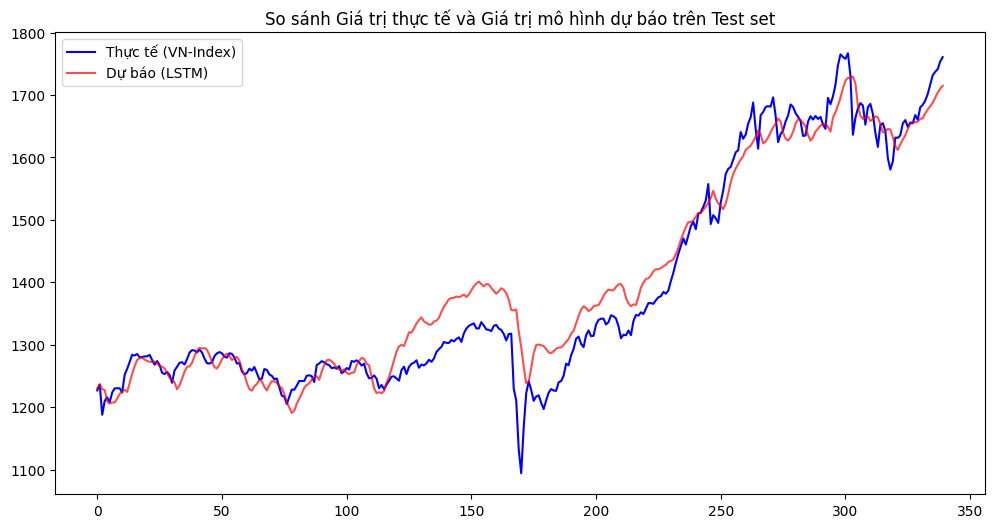

In [6]:
# model_path = os.path.join('..', 'models', 'best_vnindex_lstm.pth')

# Load trong so da huan luyen vao model
model.load_state_dict(torch.load(model_save_path, map_location=device))
model.to(device)

test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=final_batch_size, shuffle=False)

## Du doan tren tap test
preds, targets = predict_model(model, test_loader, device)

## Inverse lai cac gia tri
final_preds = inverse_transform_target(preds, scaler, TARGET_INDEX)
final_targets = inverse_transform_target(targets, scaler, TARGET_INDEX)

## Tinh metrics
mae, rmse, r2 = cal_metrics(final_targets, final_preds)

print(f"MAE: {mae:.2f} điểm")
print(f"RMSE: {rmse:.2f} điểm")
print(f"R2 Score: {r2:.4f}")

## Luu ket qua

metrics_path = os.path.join(RESULT_DIR, 'evaluation_metrics.txt')
with open(metrics_path, 'w') as f:
    f.write(f"MAE: {mae:.4f}\n")
    f.write(f"RMSE: {rmse:.4f}\n")
    f.write(f"R2 Score: {r2:.4f}\n")

# Ve bieu do truc quan giua gia tri thuc te va gia tri du doan
plt.figure(figsize=(12,6))
plt.plot(final_targets, label='Thực tế (VN-Index)', color='blue')
plt.plot(final_preds, label='Dự báo (LSTM)', color='red', alpha=0.7)
plt.title('So sánh Giá trị thực tế và Giá trị mô hình dự báo trên Test set')
plt.legend()

pred_chart_path = os.path.join(FIGURE_DIR, 'prediction_chart.png')
plt.savefig(pred_chart_path)

plt.show()

In [7]:
# Tai cac file luu param, model, ...

import os
from google.colab import files

targets = ['models', 'results', 'figures']
found_paths = []

for target in targets:
    if os.path.exists(target):
        found_paths.append(target)
    elif os.path.exists(os.path.join('..', target)):
        found_paths.append(os.path.join('..', target))

if found_paths:
    paths_str = " ".join(found_paths)
    exit_code = os.system(f"zip -r training_results.zip {paths_str}")
    if exit_code == 0:
        files.download('training_results.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>